# Тестовое задание

Задача:

1. Написать `SQL` запрос для выгрузки данных из `Clickhouse`
2. Дообработать получившиеся данные в `Python`
3. Сделать визуализацию (графики)
    - Когортное `ARPU` (по дням, неделям и месяцам)
    - Когортный `Retention` (по дням, неделям и месяцам)
4. Проанализировать результаты - что произошло с метриками, есть ли аномалии?
5. Закоммитить `Python` код в свой `github`

## Подключение к БД, импорт библиотек и открытие данных

Импортируем библиотеки

In [1]:
from clickhouse_driver import Client

import pandas as pd
import numpy as np
import datetime

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib import pyplot as plt

from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

Подключаемся к БД

In [2]:
client = Client(host="dev-01.aksimemor.me",
port= "9000",
database= "default",
user= "thanos",
password= "show_me_your_data")


Напишем функцию для вывода данных

In [3]:
def select(sql):
    return client.query_dataframe(sql)

Напишем SQL запрос

In [4]:
query = ''' SELECT *
            FROM marvel
        '''

Сохраним данные в переменную df

In [5]:
df = select(query)

Рассмотрим данные.

In [6]:
df.head()

user_id        installed_at  \
0  0cc89e46-55b4-dfb5-0095-0fb01928c395 2019-12-26 03:38:47   
1  0cc89e46-55b4-dfb5-0095-0fb01928c395 2019-12-26 03:38:47   
2  0cc89e46-55b4-dfb5-0095-0fb01928c395 2019-12-26 03:38:47   
3  0cc89e46-55b4-dfb5-0095-0fb01928c395 2019-12-26 03:38:47   
4  87c3e898-da20-0d91-04fe-7333bf99e479 2019-12-18 13:18:44   

           created_at  day country app_version_short  last_time_spent  \
0 2020-03-27 14:40:38   92      us             1.7.4                0   
1 2020-03-27 16:25:38   92      us             1.7.4                0   
2 2020-03-28 01:11:46   92      us             1.7.4                0   
3 2020-03-31 16:32:22   96      us             1.7.4                0   
4 2020-02-15 10:51:03   58      vn             1.6.4                0   

   lifetime_session_count activity_kind   event_name  reporting_revenue  
0                      12         event  revenue_all            2.99000  
1                      13         event  revenue_all            6.99000  
2                      17         event  revenue_all            6.99000  
3                      36         event  revenue_all            9.99000  
4                      57         event  revenue_all            4.68626

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16811210 entries, 0 to 16811209
Data columns (total 11 columns):
user_id                   object
installed_at              datetime64[ns]
created_at                datetime64[ns]
day                       int64
country                   object
app_version_short         object
last_time_spent           int64
lifetime_session_count    int64
activity_kind             object
event_name                object
reporting_revenue         float64
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 1.4+ GB


In [8]:
df.shape

(16811210, 11)

У нас датафрейм с 16811210 строк и 11 столбцов.

Столбцы следующие:

- user_id:                id игрока
- installed_at:           Дата и время установки
- created_at :            Дата и время события
- day:                    День жизни игрока с момента установки
- country:                Страна пользователя в момент совершения события
- app_version_short:      Версия мобильного приложения
- last_time_spent:        Продолжительность последней сессии в секундах
- lifetime_session_count: Общее кол-во сессий игрока к данному событию
- activity_kind:          Тип события
- event_name:             Название события
- reporting_revenue:      Выручка

## Предобработка данных

Проверим дубликаты

In [9]:
df.duplicated().sum()

137

Удалим их

In [10]:
df.drop_duplicates(inplace = True)

In [11]:
df.duplicated().sum()

0

Дубликатов нет

Проверим пропуски

In [12]:
df.isna().sum()

user_id                   0
installed_at              0
created_at                0
day                       0
country                   0
app_version_short         0
last_time_spent           0
lifetime_session_count    0
activity_kind             0
event_name                0
reporting_revenue         0
dtype: int64

Пропусков нет

## Исследование данных

Проведем первичный взгляд на данные. Рассмотрим следующее:
- количество установок в день
- количество уникальных пользователей в день
- выручку в день
- количество действий в день на игрока
- количество покупок на одного человека в день

Выделим день активности и день установки в отдельный столбец

In [13]:
df['session_date'] = df['created_at'].astype('datetime64[D]')
df['day_installed'] = df['installed_at'].astype('datetime64[D]')

Рассмотрим количество пользователей, которые установили игру по дням

In [14]:
install_date = df.groupby('day_installed')['user_id'].nunique().reset_index()

fig = px.line(install_date, x="day_installed", y="user_id", title='Установок в день')
fig.show()

- Первая установка у нас была 2019-12-16, последняя 2020-07-01
- До 25 марта количество установок довольно низкое, а после резко вырастает и колеблется от месяца к месяцу в диапозоне примерно от 10 до 40 тысяч

Рассмотрим количество уникальных пользователей в день

In [30]:
user_date = df.groupby('session_date')['user_id'].nunique().reset_index()

fig = px.line(user_date, x="session_date", y="user_id", title='Уникальных пользователей в день')
fig.show()

- Первое действие было 2020-01-17, последнее 2020-07-01
- Количество активности резко возвросло с 25 марта, учитывая предыдущий график, с количеством установок выросло количество активности

Найдем разницу с первой активности и первой установки.

In [16]:
df['created_at'].min() - df['installed_at'].min()

Timedelta('32 days 07:15:28')

32 дня прошло с момента установки, прежде чем появилась какая-то активность.

Рассмотрим выручку по дням

In [17]:
revenue_date=df.groupby('session_date')['reporting_revenue'].sum().reset_index()

fig = px.line(revenue_date, x='session_date', y='reporting_revenue', title='Выручка в день')
fig.show()

- Выручка по месяцам распределена неравномерно
- Имеется резкий рост выручки в коне января, затем резкий спад и затем постепеный рост до середины марта, после чего выручка колеблится.

Рассмотрим количество действий на человека в день

In [19]:
sessions_count = df.groupby('session_date').agg({'user_id': ['count', 'nunique']}).reset_index()
sessions_count.columns = ['session_date', 'n_sessions', 'n_users']
sessions_count['sessions_per_user'] = sessions_count['n_sessions'] / sessions_count['n_users']

fig = px.line(sessions_count, x="session_date", y="sessions_per_user", title='Количество действий на одного человека в динамике', labels={'session_date':'Дата сессии', 'sessions_per_user':'Кол-во сессий на одного пользователя'})
fig.show()

- До 30 января на одного человека приходится от 0 до 4 действий, метрика в целом довольная нестабильна
- С 30 янваля по 25 марта метрика колеблится между значениями 1.2 - 1.4
- С 26 марта метрика поднимается примерно до 2 и держится до 1 июля

Рассмотрим количество покупок на одного человека 

In [20]:
buy_count = df.query('reporting_revenue > 0').groupby('session_date').agg({'reporting_revenue':'count'}).reset_index()
user_count = df.groupby('session_date').agg({'user_id':'nunique'}).reset_index()
buy_count = buy_count.merge(user_count, on = 'session_date')

buy_count.columns = ['session_date','n_buy', 'day_buyers']
buy_count['buy_per_user'] = buy_count['n_buy'] / buy_count['day_buyers']

fig = px.line(buy_count, x="session_date", y="buy_per_user", title='Количество покупок на одного человека в динамике', labels={'session_date':'Дата сессии', 'sessions_per_user':'Кол-во сессий на одного пользователя'})
fig.show()

- Количество покупок в январе 2020 меняется в диапазоне от 1 до 4 покупок на пользователя, затем в период с февраля по 25 марта, метрика стабилизируется и находится между 1.2 - 1.4 покупки в день, после 25 марта количество покупок на человека резко снижается и стремиться к нулю.

### Вывод

По данным графикам можно выделить 3 периода:
- с 16 декабря 2019 по 30 января 2020 (1 этап)
- с 31 января 2020 по 25 марта 2020 (2 этап)
- с 26 марта по 1 июля 2020 (3 этап)

Предположу, что 1 этап, это время запуска или тестирования игры: маленькое количество установок, немного активностей, с момента первой установки первое событие произошло спустя месяц.

2 этап, это время бета-теста, либо результат рекламы: количество пользователей немного прибавилось, событий в день немного увеличилось, метрики количества действий и покупок на одного человека стабилизировались.

С 26 марта третий этап, либо момент релиза, либо начало активной рекламной кампании: количество пользователей резко возросло, количество действий на человека аналогично возросло.

Выручка по дням выглядит довольно странно. На 1 этапе мало пользователей, но выручки довольно высокие, а на 3 этапе выручки чуть выше, относительно первого этапа, но пользователей значительно больше. Выглядит как аномалия.

Предположу, что в первом этапе проходили тесты платежной системы и программа регистрировала это как покупку. В ином случае, если это не тесты, то на старте пришла core аудитория, которая много платит. Во втором этапе пришла менее платящая аудтория, на третьем этапе игра стала массовой.

## ARPU

Рассчитаем среднюю выручку на игрока с помощью когортного анализа. Рассмотрим месячные когорты, недельные и дневные.

Сделаем столбцы с месяцем установки, месяцем действия и этапом жизни.

In [21]:
df['session_month'] = df['created_at'].astype('datetime64[M]')
df['month_installed'] = df['installed_at'].astype('datetime64[M]')

df['month'] = (df['session_date'] - df['installed_at'])
df['month'] = df['month'] / np.timedelta64(1, 'M')
df['month'] = round(df['month']).astype('int')

Построим тепловую карту по месячным когортам.

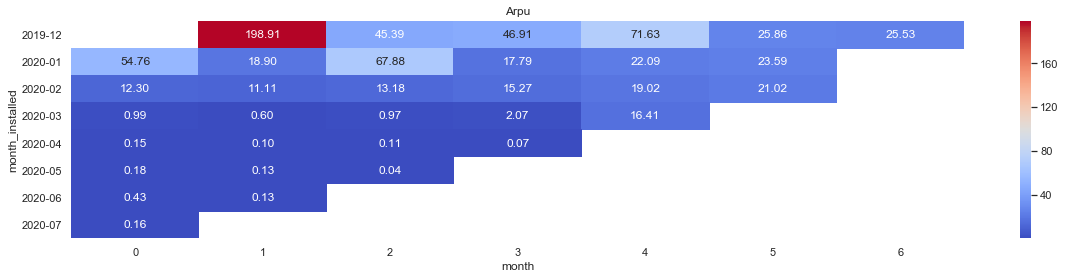

In [22]:
cohorts_month = df.groupby(['month_installed','month']).agg({'user_id':'nunique', 'reporting_revenue':'sum'}).reset_index() 

cohorts_month['arpu'] = cohorts_month['reporting_revenue']/cohorts_month['user_id']

cohorts_month['month_installed'] = cohorts_month['month_installed'].dt.strftime('%Y-%m')

arpu_pivot_month = cohorts_month.pivot_table(
    index='month_installed',
    columns='month',
    values='arpu',
    aggfunc='mean',
) 

sns.set(style='white')
plt.figure(figsize=(20, 4))
plt.title('Arpu')
sns.heatmap(arpu_pivot_month, annot=True, fmt='.2f', cmap= 'coolwarm')

### Вывод

Сопоставляя с предыдущими графиками, мы ожидаемо видим, что у первой когорты отсутствуют данные за нулевой этап жизни когорты. 

Пиковые значения наблюдаются у первой когорты на старте жизни. Это обусловлено тем, что игроков довольно мало, а выручки весьма высокие.

Весьма низкие значения начинаются с мартовской когорты игроков. Количество пользователей значительно выросло, а выручка нет.

Проведем когортный анализ по неделям

Для начала сделаем столцы с началом недели установки игры, сессии игры и недельный этап жизни когорты

In [23]:
df['session_week'] = pd.to_datetime(
    df['session_date'], unit='d'
) - pd.to_timedelta(df['session_date'].dt.dayofweek, unit='d')

df['week_installed'] = pd.to_datetime(
    df['day_installed'], unit='d'
) - pd.to_timedelta(df['day_installed'].dt.dayofweek, unit='d')

df['week'] = (df['session_week'] - df['week_installed'])
df['week'] = pd.to_numeric(df['week']/ np.timedelta64(1, 'W'))
df['week'] = round(df['week']).astype('int')

Построим тепловую карту

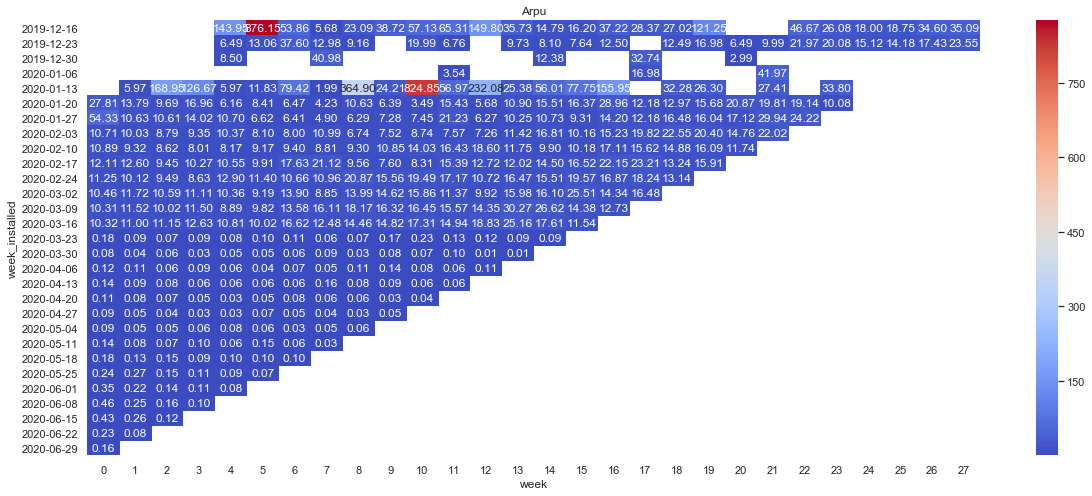

In [24]:
cohorts_week= df.groupby(['week_installed','week']).agg({'user_id':'nunique', 'reporting_revenue':'sum'}).reset_index() 

cohorts_week['arpu'] = cohorts_week['reporting_revenue']/cohorts_week['user_id']

cohorts_week['week_installed'] = cohorts_week['week_installed'].dt.strftime('%Y-%m-%d')

arpu_pivot_week = cohorts_week.pivot_table(
    index='week_installed',
    columns='week',
    values='arpu',
    aggfunc='mean',
)

sns.set(style='white')
plt.figure(figsize=(20, 8))
plt.title('Arpu')
sns.heatmap(arpu_pivot_week, annot=True, fmt='.2f',cmap= 'coolwarm') #, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = False); 

### Вывод

Данный график является более подробной версии предыдущего. 

На нем видно, что когорты игроков от 2019-12-30 и 2020-01-06 совершала покупки реже остальных - есть пропуски. Предположу, что пришло меньше игроков из-за празнования Нового Года.

Так же стоит отметить высокие значения у 2019-12-16 когорты на 5 этапе жизни и у когорты 2020-01-13 на 10 этапе жизни.

Рассмотрим ARPU на каждый день.

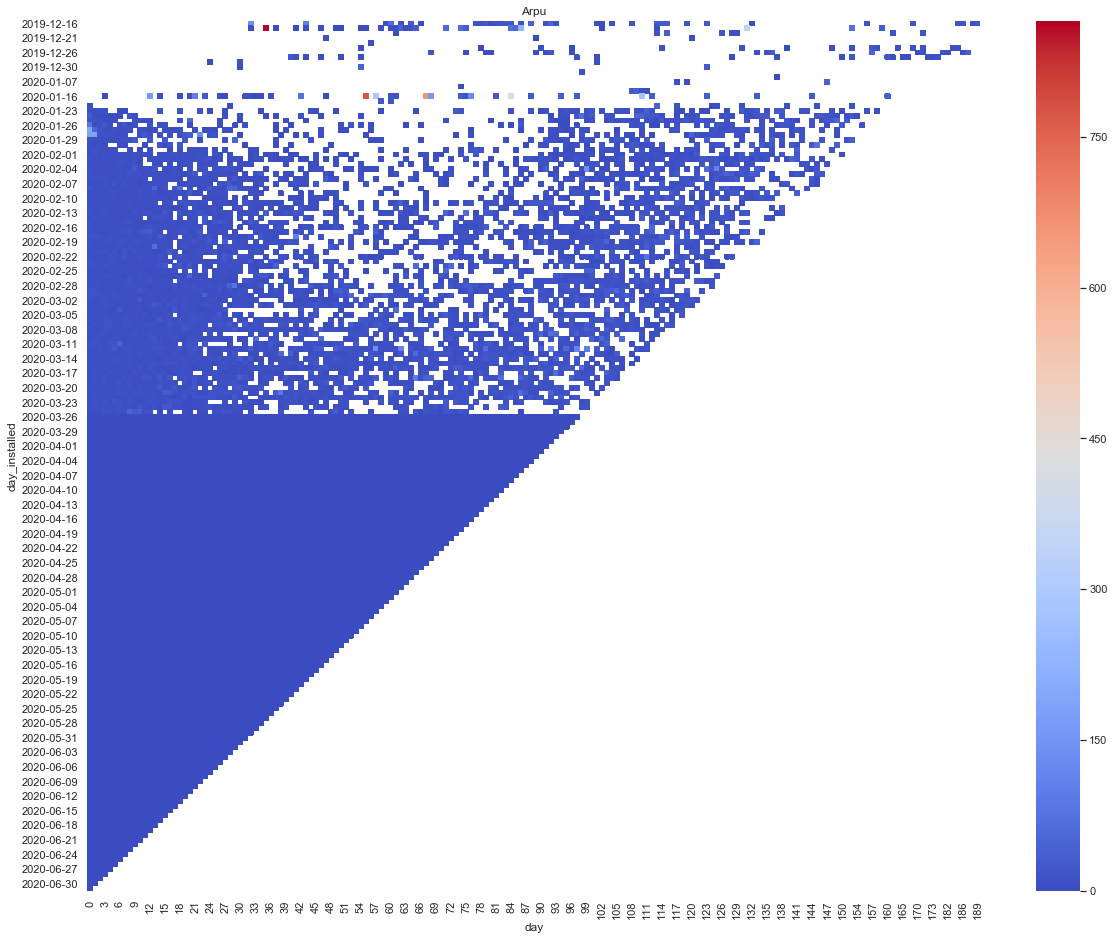

In [25]:
cohorts_daily= df.groupby(['day_installed','day']).agg({'user_id':'nunique', 'reporting_revenue':'sum'}).reset_index() 

cohorts_daily['arpu'] = cohorts_daily['reporting_revenue']/cohorts_daily['user_id']

cohorts_daily['day_installed'] = cohorts_daily['day_installed'].dt.strftime('%Y-%m-%d')

arpu_pivot_daily = cohorts_daily.pivot_table(
    index='day_installed',
    columns='day',
    values='arpu',
    aggfunc='mean',
)

sns.set(style='white')
plt.figure(figsize=(20, 16))
plt.title('Arpu')
sns.heatmap(arpu_pivot_daily, cmap= 'coolwarm')

### Вывод

Рассматривая данную тепловую карту в контексте раннее выделенных этапов, можно сказать следующее:
- В первом этапе мы видим, покупки совершались редко, много пустых значений. Особо выделяется один день из первых когорт. Максимальное значение на графике. 
- Во втором этапе покупки стади совершаться чаще, пустых значений меньше относительно первого этапа. Так же присутствует одно значение, которое выделяется.
- На третьем этапе покупки совершались каждый день, но относительно количества пользователей выручка упала, соответственно метрика показывает значения близкие к нулю

## Retention Rate

С помощью когортного анализа рассмотрим Retention Rate.

Построим тепловую карту по месячным когортам.

Удалим нулевой этап жизни, так как там будет 100 процентов

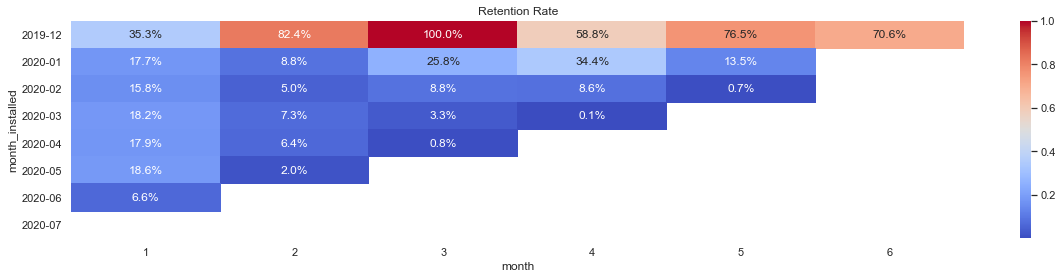

In [26]:
cohorts= df.groupby(['month_installed','month']).agg({'user_id':'nunique'}).reset_index() 
initial_users_count = cohorts.groupby('month_installed')['user_id'].max().reset_index()
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})
    
cohorts = cohorts.merge(initial_users_count,on='month_installed')
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users'] 

cohorts['month_installed'] = cohorts['month_installed'].dt.strftime('%Y-%m')

retention_pivot = cohorts.pivot_table(
    index='month_installed',
    columns= 'month',
    values='retention',
    aggfunc='sum',
)

retention_pivot.drop(0, axis = 1, inplace = True)
    
sns.set(style='white')
plt.figure(figsize=(20, 4))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, cmap= 'coolwarm', annot=True, fmt='.1%')

### Вывод

Первая когорта показывает относительно высокий retention. На третий этап жизни у когорты 100%. Вспоминая результаты предыдущих исследований, можно предположить, что это обусловленно небольшим количеством игроков. В целом, довольно нетипичное поведение второй когорты, обусловлено тем же: в первый этап жизни всего 17.7%, затем 8.8%, потом 25.8% и т.д. Так же предположу, что это могла быть core аудитория, которая могла возвращаться из-за обновлений или ивентов в игре.

Дальше когорты показывают более "ожидаемое" поведение. Это происходит из-за того, что в игру пришло больше игроков.

Построим тепловую карту по неделям.

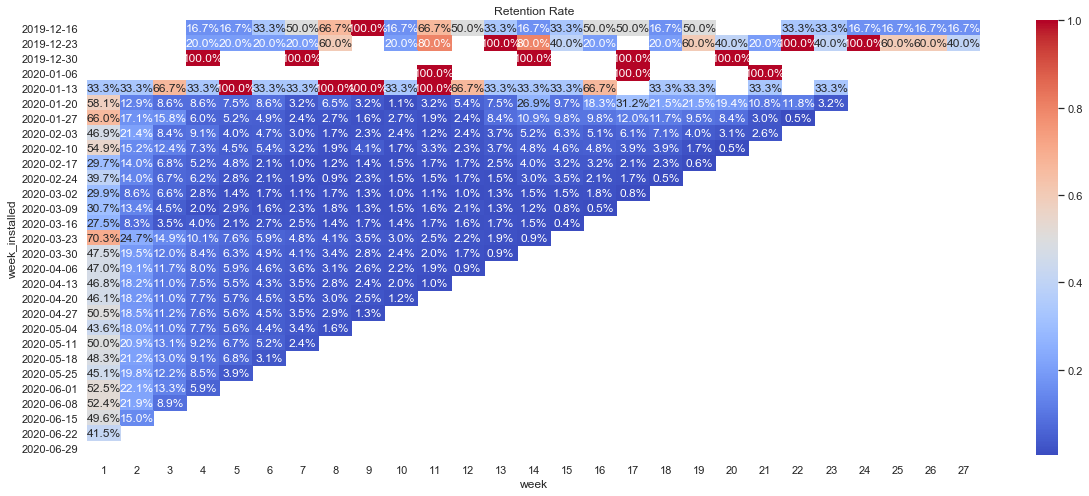

In [27]:
cohorts = df.groupby(['week_installed','week']).agg({'user_id':'nunique'}).reset_index() 
initial_users_count = cohorts.groupby('week_installed')['user_id'].max().reset_index()
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})
    
cohorts = cohorts.merge(initial_users_count,on='week_installed')
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users'] 

cohorts['week_installed'] = cohorts['week_installed'].dt.strftime('%Y-%m-%d')

retention_pivot = cohorts.pivot_table(
    index='week_installed',
    columns= 'week',
    values='retention',
    aggfunc='sum',
)

retention_pivot.drop(0, axis = 1, inplace = True)
    
sns.set(style='white')
plt.figure(figsize=(20, 8))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, cmap= 'coolwarm', annot=True, fmt='.1%')

### Вывод

Когорты из первого этапа показывают высокий нестабильный Retention c пропусками значений. Обусловденно все тем же, мало игроков, которые с определенной периодичностью возвращаются.

На втором и третьем этапе довольно высокий retention первого этапа жизни. 

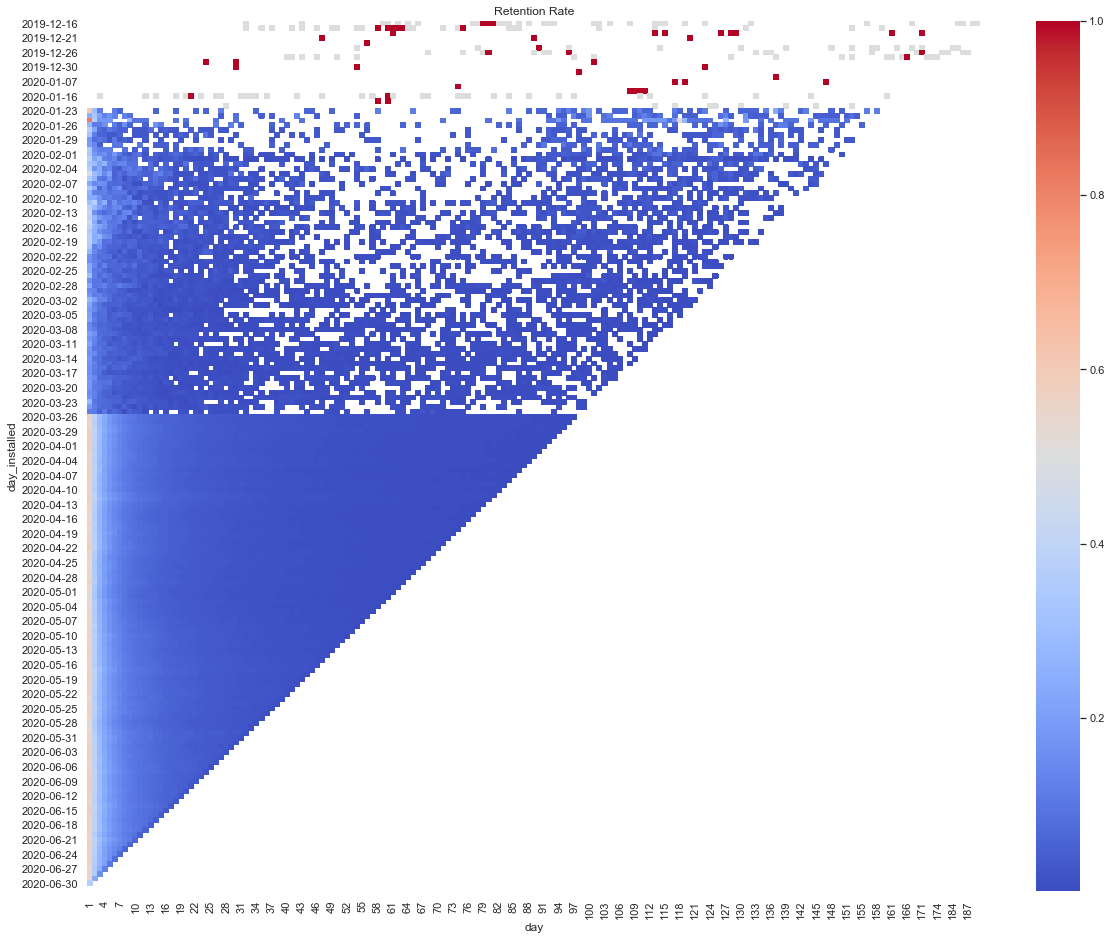

In [28]:
cohorts = df.groupby(['day_installed','day']).agg({'user_id':'nunique'}).reset_index() 
initial_users_count = cohorts.groupby('day_installed')['user_id'].max().reset_index()
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})
    
cohorts = cohorts.merge(initial_users_count,on='day_installed')
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users'] 

cohorts['day_installed'] = cohorts['day_installed'].dt.strftime('%Y-%m-%d')

retention_pivot = cohorts.pivot_table(
    index='day_installed',
    columns= 'day',
    values='retention',
    aggfunc='sum',
)

retention_pivot.drop(0, axis = 1, inplace = True)
    
sns.set(style='white')
plt.figure(figsize=(20, 16))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, cmap= 'coolwarm')

### Вывод

В разрезе этапов по данному графику можно сказать следующее:
- В первом этапе пиковые значения либо серединные. Много пропусков. Обусловленно это тем, что в дневных когортах мало людей, которые возвращаются в игру нестабильно.
- Во втором этапе тепловая карта не такая "дырявая", пользователей больше.
- В третьем этапе из-за значительно большего количества человек в тепловой карте нет пропусков. Так же когорты показывают высокий retention первого дня.